# Libraries

In [57]:
import pandas as pd
import os
import datetime
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Read Data

In [2]:
#ignore pandas warnings
warnings.filterwarnings('ignore')

#filename
file_name="events_log.csv.gz"

#path file
data_path = os.path.join("../data/")
data_path_file = data_path + file_name

#read and write to transform integer timestamp in the correct format
data = pd.read_csv(data_path_file, compression='gzip',dtype={'timestamp': 'Int64'})
data.to_csv(data_path+'new_events_log.csv')
data = pd.read_csv(data_path+"new_events_log.csv",
                     parse_dates=['timestamp'], 
                     index_col='timestamp')   
# drop extra column
data = data.drop('Unnamed: 0',axis=1)

In [3]:
data.head()

,uuid,session_id,group,action,checkin,page_id,n_results,result_position
timestamp,,,,,,,,
2016-03-01 10:38:42,00000736167c507e8ec225bd9e71f9e5,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN
2016-03-07 00:52:26,00000c69fe345268935463abbfa5d5b3,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN
2016-03-02 14:53:05,00003bfdab715ee59077a3670331b787,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN
2016-03-02 22:27:01,0000465cd7c35ad2bdeafec953e08c1a,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0
2016-03-02 09:50:23,000050cbb4ef5b42b16c4d2cf69e6358,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN


# Overall clickthrough rate

In [4]:
CT_x_Day  = data.groupby([pd.TimeGrouper('D')]).apply(lambda row: 
                                  len(row[row['action'] == 'visitPage']))
Searches_x_Day = data.groupby([pd.TimeGrouper('D')]).apply(lambda row: 
                                  len(row[row['action'] == 'searchResultPage']))
Daily_avg = CT_x_Day / Searches_x_Day

Daily_avg

timestamp
2016-03-01    0.362142
2016-03-02    0.354037
2016-03-03    0.343129
2016-03-04    0.257511
2016-03-05    0.251666
2016-03-06    0.257186
2016-03-07    0.247962
2016-03-08    0.251457
Freq: D, dtype: float64

In [5]:
CT_x_Day_group  = data.groupby([pd.TimeGrouper('D'),'group']).apply(lambda row: 
                                  len(row[row['action'] == 'visitPage']))
Searches_x_Day_group = data.groupby([pd.TimeGrouper('D'),'group']).apply(lambda row: 
                                  len(row[row['action'] == 'searchResultPage']))
Daily_avg_group = CT_x_Day_group / Searches_x_Day_group

Daily_avg_group

timestamp   group
2016-03-01  a        0.470911
            b        0.125863
2016-03-02  a        0.449088
            b        0.133497
2016-03-03  a        0.434864
            b        0.135907
2016-03-04  a        0.299257
            b        0.169797
2016-03-05  a        0.291802
            b        0.176394
2016-03-06  a        0.306368
            b        0.166634
2016-03-07  a        0.284274
            b        0.174905
2016-03-08  a        0.295957
            b        0.161410
dtype: float64

# Which Results Do Clients Click First?

In order to figure out which links clients click first we have get the number of search result pages that were clicked on and group by day, session_id and result_positon.

In [6]:
#select visits, sort by timestamp and group by the day and session_id and take the first result in the column corresponding to the result_position column

First_Click = data[data.action == 'visitPage'].sort_index().groupby([pd.TimeGrouper('D'),'session_id',], sort=True)['result_position']\
                             .first()
First_Click.head()

timestamp   session_id      
2016-03-01  001e2d0e159172d2    2.0
            0024c4506bf92e1c    1.0
            0029420a5f8c7d90    1.0
            002b97995ca9ce77    3.0
            003037c8d3c3fe94    2.0
Name: result_position, dtype: float64

In [7]:
First_click_by_day =pd.DataFrame(First_Click).reset_index().groupby(['timestamp','result_position']).apply(lambda row: 
                                  len(row))

In [8]:
First_click_by_day.groupby(['timestamp']).head(10)

timestamp   result_position
2016-03-01  1.0                2383
            2.0                 506
            3.0                 223
            4.0                 114
            5.0                  85
            6.0                  42
            7.0                  34
            8.0                  18
            9.0                  17
            10.0                 19
2016-03-02  1.0                2396
            2.0                 486
            3.0                 274
            4.0                 137
            5.0                  70
            6.0                  57
            7.0                  32
            8.0                  34
            9.0                  25
            10.0                 10
2016-03-03  1.0                2422
            2.0                 485
            3.0                 258
            4.0                 123
            5.0                  80
            6.0                  59
            7.0                  42


# What Are The Daily Average Zero Results Rate?

In [9]:
zero_res = data.groupby([pd.TimeGrouper('D')]).apply(lambda row: 
                                                   len(row[row['n_results'] == 0]))
    
proportion_zeros = zero_res / Searches_x_Day
proportion_zeros

timestamp
2016-03-01    0.187602
2016-03-02    0.189874
2016-03-03    0.179707
2016-03-04    0.180810
2016-03-05    0.184944
2016-03-06    0.176157
2016-03-07    0.182000
2016-03-08    0.193717
Freq: D, dtype: float64

In [79]:
zero_res_groups = data.groupby([pd.TimeGrouper('D')]).apply(lambda row: 
                                                   len(row[row['n_results'] == 0]))
    
proportion_zeros_group = zero_res_groups / Searches_x_Day_group
proportion_zeros_group

timestamp   group
2016-03-01  a        0.273963
            b        0.595131
2016-03-02  a        0.271709
            b        0.630423
2016-03-03  a        0.259262
            b        0.585644
2016-03-04  a        0.266861
            b        0.560722
2016-03-05  a        0.283558
            b        0.531794
2016-03-06  a        0.271834
            b        0.500486
2016-03-07  a        0.272462
            b        0.548162
2016-03-08  a        0.289447
            b        0.585714
dtype: float64

# What Factors Affect User Session Length?

First we take the initial session

In [23]:
start_session = data.sort_index()\
                  .groupby(['session_id'], sort=True, as_index=False)\
                  .nth(0)

In [24]:
start_session.head()

,uuid,session_id,group,action,checkin,page_id,n_results,result_position
timestamp,,,,,,,,
2016-03-01 00:00:01,d6b87ce39b195ca0a5adecc48aaa6276,cbba9a98ba7b20cc,a,checkin,60.0,f79f531304a265f8,NaN,4.0
2016-03-01 00:00:02,976a1ff3925a516aba858b8ad20cb9f9,c1f0f8499c6655cd,b,checkin,20.0,88bebe600b777ea9,NaN,NaN
2016-03-01 00:00:02,2e71e942d17f5999a0e33d2b66b88520,614eaa17120fe46b,b,checkin,40.0,756d326815bc60c9,NaN,1.0
2016-03-01 00:00:05,3373b4f03236565e8e36c35388831c8a,32edcb654a1dee57,b,checkin,150.0,d6122cfa99f1809f,NaN,1.0
2016-03-01 00:00:06,f7c40cd7e0f251a78657c5c08ea585e6,34ba1f4ed8fa8368,b,checkin,90.0,b7502d32b09f32bb,NaN,NaN


Then, we calculate the last session

In [25]:
end_session = data.groupby(['session_id'], sort=True,as_index=False)\
                .nth(-1)

In [26]:
end_session.head()

,uuid,session_id,group,action,checkin,page_id,n_results,result_position
timestamp,,,,,,,,
2016-03-02 01:28:45,000104fe220a5675a270420cd6d4d4ac,485eabe5374f09e4,b,searchResultPage,NaN,4da9a64232ce947b,15.0,NaN
2016-03-01 14:41:32,0002eb91753d5a45b3fee8d4bda5e9c3,c2ff54ef26c5f5a2,b,searchResultPage,NaN,40661413f4467994,10.0,NaN
2016-03-04 00:56:24,00055f9db0095e33a27c405a460e2938,4ca63ff30146a5bd,b,searchResultPage,NaN,fc1c434d8de2a692,0.0,NaN
2016-03-03 21:14:18,00086710a60057c6b30d95a6c49df9c4,94b61e1ca6eaf62a,b,searchResultPage,NaN,131391e370c8f07a,4.0,NaN
2016-03-06 19:52:50,0009cf4511fd52ab81a3f5c49a0f61dd,85ffaf044d053d54,b,searchResultPage,NaN,ee21bb97d7f6e768,0.0,NaN


Now, we create a new column in the start_session and end_session that strips the time from the index of the old dataframe

In [27]:
start_session['time'] = start_session.index.to_pydatetime()
start_session = start_session.reset_index()

end_session['time'] = end_session.index.to_pydatetime()
end_session = end_session.reset_index()

Now, we can drop some useless columns such like: uuid,checkin, page_id and timestamp

In [29]:
start_session = start_session.drop(['page_id','uuid','timestamp','checkin'],axis=1)
end_session = end_session.drop(['page_id','uuid','timestamp','checkin'],axis=1)

Then, we can merge both dataframes

In [31]:
data_merge = pd.merge(start_session, 
               end_session, 
               on='session_id',
               suffixes=('_start','_end'))
data_merge.head()

,session_id,group_start,action_start,n_results_start,result_position_start,time_start,group_end,action_end,n_results_end,result_position_end,time_end
0,cbba9a98ba7b20cc,a,checkin,NaN,4.0,2016-03-01 00:00:01,a,checkin,NaN,4.0,2016-03-01 00:00:01
1,c1f0f8499c6655cd,b,checkin,NaN,NaN,2016-03-01 00:00:02,b,checkin,NaN,NaN,2016-03-01 00:00:02
2,614eaa17120fe46b,b,checkin,NaN,1.0,2016-03-01 00:00:02,b,checkin,NaN,1.0,2016-03-01 00:00:22
3,32edcb654a1dee57,b,checkin,NaN,1.0,2016-03-01 00:00:05,b,checkin,NaN,1.0,2016-03-01 00:01:05
4,34ba1f4ed8fa8368,b,checkin,NaN,NaN,2016-03-01 00:00:06,b,checkin,NaN,NaN,2016-03-01 00:00:06


Now, we can calculate the time difference between the start and end times (in seconds)

In [32]:
session_length = data_merge['time_end'] - data_merge['time_start']
session_length = session_length.apply(lambda row: row.seconds)

Let plot the session length in a histogram:

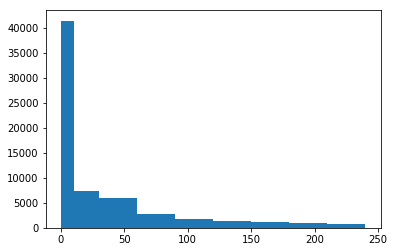

In [94]:
plot_ses_len = plt.hist(session_length, bins=bins)

From previuous graph we can observe that the majority of people spend either 10 seconds in a session. This means they probably are not finding what they want.

Now, we can split by "group" the session length and analyze it:

In [81]:
data_merge['session_length'] = session_length
session_length_by_group_a = data_merge[data_merge['group_start']=='a']['session_length'].value_counts()
session_length_by_group_b = data_merge[data_merge['group_start']=='b']['session_length'].value_counts()

plot group "a"

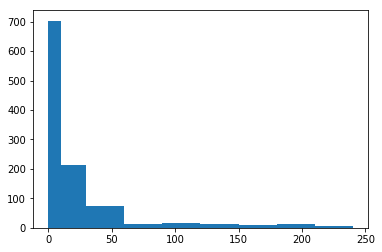

In [82]:
plot_ses_len_a = plt.hist(session_length_by_group_a, bins=bins)

plot group "b"

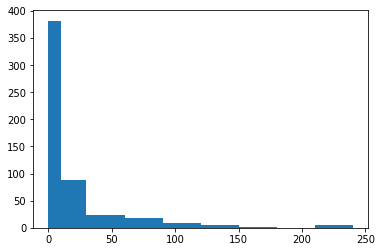

In [83]:
plot_ses_len_b = plt.hist(session_length_by_group_b, bins=bins)

From previuos graphs we can observe that the magnitudes of numbers are very different between the two groups but the shape of the distributions are roughly the same. Let's take a look at how the percentages change between the two groups:

In [84]:
tot_a = session_length_by_group_a.sum()
session_length_a_perce = session_length_by_group_a / tot_a

In [91]:
session_length_a_perce.sort_index().head(20)

0     0.311551
1     0.001427
2     0.006287
3     0.008190
4     0.008530
5     0.008088
6     0.007748
7     0.006491
8     0.006932
9     0.007102
10    0.006321
11    0.006762
12    0.011316
13    0.009617
14    0.008835
15    0.008224
16    0.007544
17    0.007374
18    0.006389
19    0.006898
Name: session_length, dtype: float64

In [92]:
tot_b = session_length_by_group_b.sum()
session_length_b_perce = session_length_by_group_b / tot_b

In [93]:
session_length_b_perce.sort_index().head(20)

0     0.715577
1     0.002176
2     0.010026
3     0.013160
4     0.010751
5     0.009508
6     0.007746
7     0.006839
8     0.006192
9     0.006554
10    0.005958
11    0.005803
12    0.006658
13    0.006839
14    0.005492
15    0.005440
16    0.004430
17    0.003653
18    0.003705
19    0.002979
Name: session_length, dtype: float64

From previous percentages we can observe that the group "b" has the largest percentage of people with zero session length in comparison with group "a".